# base_model

> In this module we have the base model, learner and other things we need to train encoder
 

In [ ]:
#| default_exp base_model

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm
from base_rbt.helper import *

Here we have the base functions and classes to train a basic BT-style model. Note that this (mostly) all comes directly from here: `https://github.com/KeremTurgutlu/self_supervised/blob/main/nbs/14%20-%20barlow_twins.ipynb`
but we needed to extend some of the functionality for our purposes. 

Some of the base classes and functions needed for image augmentation pipeline:

In [ ]:
#| export

#My edited version of RandTransform
class RandomGaussianBlur(RandTransform):
    "Randomly apply gaussian blur with probability `p` with a value of s"
    order = 11
    def __init__(self, 
                 p=1.0, #debugging (bug in libraries implementation)
                 prob=0.5,#the real probability
                 s=(8,32), #kernel
                 sig=None, #sig_val is either manually input OR
                 blur_r=(0.1,2),#is randomly chosen from uniform with these bounds
                 same_on_batch=False, 
                 **kwargs): 
        
        store_attr()
        super().__init__(p=p, **kwargs)

    def encodes(self, x:TensorImage):
        
        if isinstance(self.s, int):   s = (self.s,self.s)
        elif isinstance(self.s, tuple) or isinstance(self.s, list): s=self.s
     
        #Default for ImageNet from BYOL / BT papers
        if self.sig is None:
            sig_val = np.random.uniform(self.blur_r[0],self.blur_r[1])
        
        else:
            sig_val = self.sig
            

        tfm = korniatfm.RandomGaussianBlur(kernel_size=s,sigma=(sig_val,sig_val),same_on_batch=self.same_on_batch,p=self.prob)
        return tfm(x)

#Delete later: leaving for backward compatibility for now
# class RandomGaussianBlur(RandTransform):
#     "Randomly apply gaussian blur with probability `p` with a value of s"
#     order = 11
#     def __init__(self, p=0.5, s=(8,32), same_on_batch=False, **kwargs): 
#         store_attr()
#         super().__init__(p=p, **kwargs)
        
#     def encodes(self, x:TensorImage):
#         if isinstance(self.s, tuple): s = np.random.randint(*self.s)
#         if isinstance(self.s, list):  s = np.random.randint(*self.s)
#         if isinstance(self.s, int):   s = self.s
#         s2 = int(s/4)*2+1
#         tfm = korniatfm.RandomGaussianBlur((s2,s2),(s,s),same_on_batch=self.same_on_batch,p=1.) #p=1. is a bug
#                                             #kernel #sigma
        
#         return tfm(x)
    
def get_BT_batch_augs(size,
                    flip=True,crop=True,noise=True,rotate=True,jitter=True,bw=True,blur=True,solar=True, #Whether to use  given aug or not
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.025, rotate_deg=30,jitter_s=.6,blur_s=(4,32),blur_r=(0.1,2),blur_sig=None,sol_t=0.05,sol_a=0.05, #hps of diff augs
                    flip_p=0.5, rotate_p=0.3,noise_p=0.2, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=imagenet_stats,cuda=default_device().type == 'cuda',xtra_tfms=[]):
    "Input batch augmentations implemented in tv+kornia+fastai"
    
    tfms = []

    korniatfm.RandomHorizontalFlip.order = RandomResizedCrop.order-1
    
    if crop: tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    
    #Unfortunately for some reason this doesn't work, so we can't apply "same_on_batch=False"
    #tfms += [korniatfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio, same_on_batch=same_on_batch)]
    
    if flip: tfms += [korniatfm.RandomHorizontalFlip(p=flip_p,same_on_batch=same_on_batch)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

                                             #brightness,contrast,saturation,hue
    if jitter: tfms += [korniatfm.ColorJitter(0.4*jitter_s, 0.4*jitter_s, 0.2*jitter_s, 0.1*jitter_s, p=jitter_p, same_on_batch=same_on_batch)]
    
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]
        
    #sig will usually be None
    if blur:   tfms += [RandomGaussianBlur(prob=blur_p, s=blur_s,sig=blur_sig,blur_r=blur_r, same_on_batch=same_on_batch)]

    korniatfm.RandomSolarize.order = RandomGaussianBlur.order + 1 #we want to apply solarization after RandomGaussianBlur
    
    if solar: tfms += [korniatfm.RandomSolarize(p=sol_p,thresholds=sol_t, additions=sol_a,same_on_batch=same_on_batch)]

    
    if noise: tfms+=[korniatfm.RandomGaussianNoise(mean=0.0, std=noise_std, same_on_batch=False, p=noise_p)]
    
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms

    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

@delegates(get_BT_batch_augs)
def get_multi_aug_pipelines(size, **kwargs): return get_BT_batch_augs(size, **kwargs)

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(size=size,**kwargs)


Base functions / classes we need to train a BT / RBT model.

In [ ]:
#| export
#Base functions / classes we need to train a BT / RBT model.

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):
        self.encoder = encoder
        self.projector = projector
        
    def forward(self,x): 
        
        return self.projector(self.encoder(x))

def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        
        self.index=-1 #Gets updated after each batch
        self.seed = np.random.randint(0,10000) #gets updated after each batch
        self.acc_dict = {}
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: 
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1  
  
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:

            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
            
            #print(xi.shape)
                                    
        elif self.n_in == 3:
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()
        
    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [ ]:
#| export
#Here we give the model API for `new idea` or `RAT` -> i.e. two projector networks

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
class P2BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector,projector2):
        self.encoder = encoder
        self.projector = projector
        self.projector2 = projector2
        
    def forward(self,x): 
        tem = self.encoder(x)
        return self.projector(tem),self.projector2(tem)

def create_p2barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    
    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)
    
    
    return P2BarlowTwinsModel(encoder, projector,projector2)


In [ ]:
#| export
#We want access to both representation and projection

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
class P3BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):
        self.encoder = encoder
        self.projector = projector
        
    def forward(self,x): 
        tem = self.encoder(x)
        return tem,self.projector(tem)
    
    def __str__(self):
        return 'forward returns tuple of (encoder(x),projector(encoder(x)))'

def create_p3barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    
 
    return P3BarlowTwinsModel(encoder, projector)



In [ ]:
#| export

class P4BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,encoder2,projector,projector2):
        self.encoder = encoder
        self.encoder2 = encoder2
        self.projector = projector
        self.projector2 = projector2
        
    def forward(self,x):
        
        #If we have multiple GPUs can take advantage of it here...
        tem,tem2 = self.encoder(x),self.encoder2(x)
        return self.projector(tem),self.projector2(tem2)

def create_p4barlow_twins_model(encoder,encoder2, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    
    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)
    
    
    return P4BarlowTwinsModel(encoder,encoder2, projector,projector2)


Here we write down standard definition of `lf` for `RAT` method: 

BarlowTwins needs an `lf` method to work properly. Here we provide the `lf` of standard barlow twins. Later we can
patch in a new defintion of `lf` that involves random functions, inner maximization etc. The tools needed to do this are provised in `base_lf`

In [ ]:
#| export
def lf_bt(pred,I,lmb):
    bs,nf = pred.size(0)//2,pred.size(1)
    
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    loss = (cdiff*I + cdiff*(1-I)*lmb).sum() 
    return loss

In [ ]:
#| hide
@patch
def lf(self:BarlowTwins, pred,*yb):
    return lf_bt(pred, self.I,self.lmb)

Here we show how to use the above functions in an end to end fashion. First we get some data and plonk it into a dls, Then create an encoder, an augmentation pipeline, a learner, then fit
the learner. This is the complete process of training BT. 

In [ ]:
#| export
def show_bt_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwins(aug,n_in=n_in,print_augs=print_augs)])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins.show(n=n)

First, get some MNIST data, define a model and augmentation pipeline:

In [ ]:
#| hide
#Get some MNIST data and plonk it into a dls
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items=items.shuffle()
items = items[0:100]
split = RandomSplitter(valid_pct=0.0)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items))
dls = tds.dataloaders(bs=50,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=default_device().type)

#Define the model
size=28
ps=10
hs=10
n_in=1
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)


aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2.5),
                    rotate=True,jitter=False,noise=False,bw=False,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.2, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats)

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2.5),
                    rotate=True,jitter=False,noise=True,bw=False,blur=False,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=1.0,sol_p=0.2, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats)

#"union" if 1 and 2
aug_pipelines_12 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2.5),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.2, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats)

aug_pipelines = [aug_pipelines_1,aug_pipelines_1]
tem = BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[tem])
#learn.fit(2)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 2.5), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 2.5), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 2.5), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 2.5), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


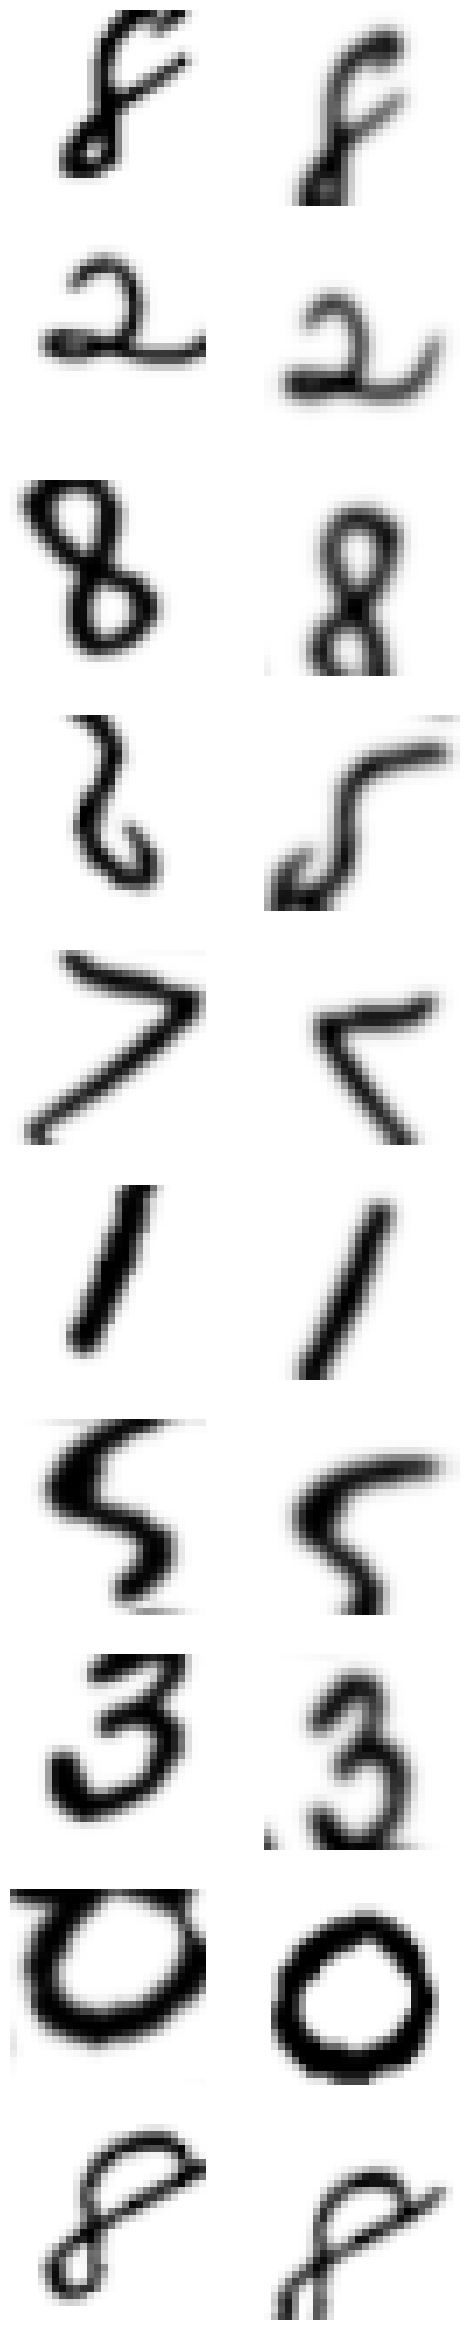

In [ ]:
#| hide
show_bt_batch(dls=dls,n_in=1,aug=aug_pipelines,n=10,print_augs=True)

Then we define the learner and take a look at the augmentations used:

For completeness, here is an example on CIFAR10

In [ ]:
#| hide
n_in=3
size=32
bs=100
path = untar_data(URLs.CIFAR)
items = get_image_files(path / "train")
items=items.shuffle()
items = items[0:200]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items)) #Or do we want this?

dls = tds.dataloaders(bs=bs,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=default_device().type)

fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                                                 bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                 resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
                                                 bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.5,sol_p=0.0,
                                                 stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                 )

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                                                 bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                 resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
                                                 bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.1,sol_p=0.2,
                                                 stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                 )

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)])
#learn.fit(1)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 5, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 5, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],



In [ ]:
print('foo')

Here are the augmentations used:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 5, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 5, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],



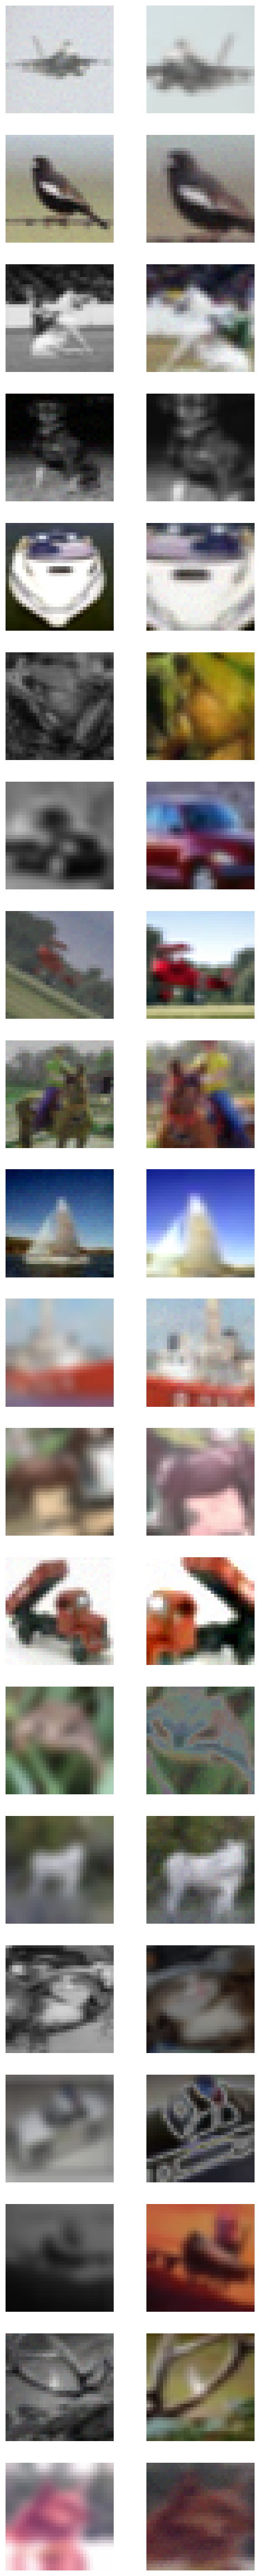

In [ ]:
#| hide
show_bt_batch(dls=dls,n_in=n_in,aug=aug_pipelines,n=20,print_augs=True)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()